# Predicting Cognitive Trajectories in Alzheimer's Disease

This notebook explores the following clinical question:

**"What will be the cognitive status of an Alzheimer's patient in 3 years, based on data from their two previous visits?"**

We use two data files:
- `historical_data.csv`: longitudinal data from many Alzheimer's patients, including clinical, cognitive, and biological features from different visits.
- `clinician_patient.csv`: two visits from a single patient, for whom we want to make a prediction.

Our work is inspired by the following research paper, which helped us understand and define the problem:

> Schiratti, J.B. et al. (2023). *Forecasting individual progression trajectories in Alzheimer’s disease*.  
> *Nature Communications*, 14(1), 761.  
> [https://www.nature.com/articles/s41467-022-35712-5](https://www.nature.com/articles/s41467-022-35712-5)

In that paper, the authors use a statistical method and compare it with a standard recurrent neural network (RNN).

In our project, we go further by testing a **Bidirectional LSTM (BiLSTM)** network — a more advanced type of RNN. It can better learn from the patient's history by looking at the sequence of visits in both forward and backward directions.

### Goals of this notebook:
1. Prepare and structure the patient visit data.
2. Train a BiLSTM model using past visit data.
3. Predict the patient’s cognitive scores at 36 months.
4. Provide clear and useful results to help clinical decisions.

### What we predict:
- `MMSE_TOT`: Mini-Mental State Exam.
- `ADAS_TOT13`: Alzheimer's Disease Assessment Scale.
- `CDR_SOB`: Clinical Dementia Rating – Sum of Boxes.

Each part of this notebook includes explanations and comments to make the pipeline easy to follow.


## 1. Load and Explore the Dataset

We start by loading the historical dataset of Alzheimer's patients.

Each row corresponds to a clinical visit and includes:
- Patient ID and examination date
- Diagnosis and cognitive scores (MMSE, ADAS13, CDR-SOB, etc.)
- Other variables such as APOE4, MRI measurements, and CSF markers

We convert the date column, create a unique identifier for each visit, and display:
- The number of total visits
- The number of unique patients
- The distribution of visits per patient

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("historical_data.csv")

# Convert the examination date column
df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"], errors="coerce")

# Create a unique VISIT_ID for each row
df["VISIT_ID"] = [f"VISIT_{i:05d}" for i in range(len(df))]

# Show basic dataset statistics

print(f"Total number of visits: {len(df)}")
print(f"Number of unique patients: {df['ID'].nunique()}")

# Visit distribution
visits_per_patient = df.groupby("ID").size()
print(f"Max number of visits per patient: {visits_per_patient.max()}")
print(f"Average number of visits per patient: {visits_per_patient.mean():.2f}")



Total number of visits: 9814
Number of unique patients: 1679
Max number of visits per patient: 13
Average number of visits per patient: 5.85


In [ ]:
# Preview the first rows
df.head()

,ID,VISCODE,EXAMDATE,AGE_vis,SITEID,DX,AGE_bl,YEARS_SINCE_bl,P_GENDER,P_RACE,...,MES_MRI_VENTRICLES_ICV,MES_FDG,MES_PIB,MES_AV45,MES_CSF_TTAU,MES_CSF_PTAU,MES_CSF_PTAU_TTAU,MES_CSF_ABETA42,MES_CSF_TTAU_ABETA42,VISIT_ID
0,4000_F_132,bl,2005-09-08,74.300,11,0.0,74.3,0.000000,Male,White,...,0.846768,0.295020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VISIT_00000
1,4000_F_132,m06,2006-03-06,74.790,11,0.0,74.3,0.490075,Male,White,...,NaN,0.476622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VISIT_00001
2,4000_F_132,m36,2008-08-27,77.268,11,0.0,74.3,2.967830,Male,White,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VISIT_00002
3,4000_F_132,m60,2010-09-22,79.338,11,0.0,74.3,5.037650,Male,White,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VISIT_00003
4,4000_F_132,m72,2011-09-19,80.329,11,0.0,74.3,6.028750,Male,White,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VISIT_00004


## 2. Missing Values and Score Distributions

Before selecting features or training a model, it's important to understand the data quality.

We start by identifying which variables have missing values, and how frequent they are.  
We then visualize the distribution of the three main cognitive scores used as prediction targets:

- `MMSE_TOT` (higher is better)
- `ADAS_TOT13` (lower is better)
- `CDR_SOB` (lower is better)

This helps detect possible outliers or irregularities.


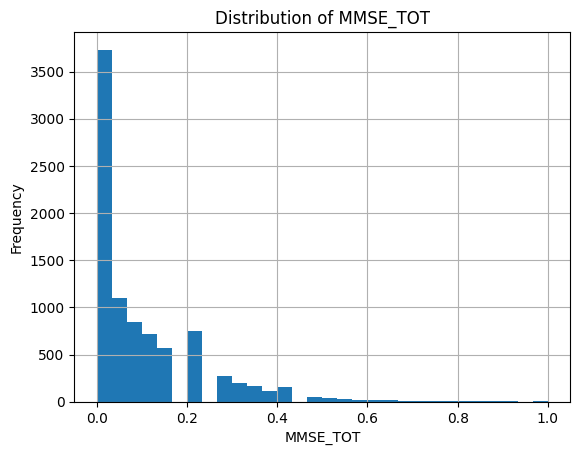

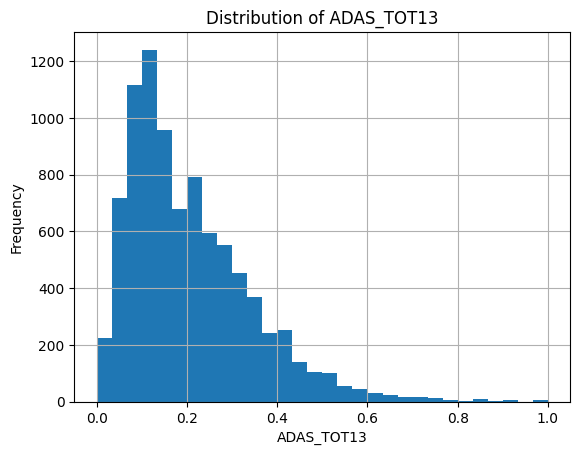

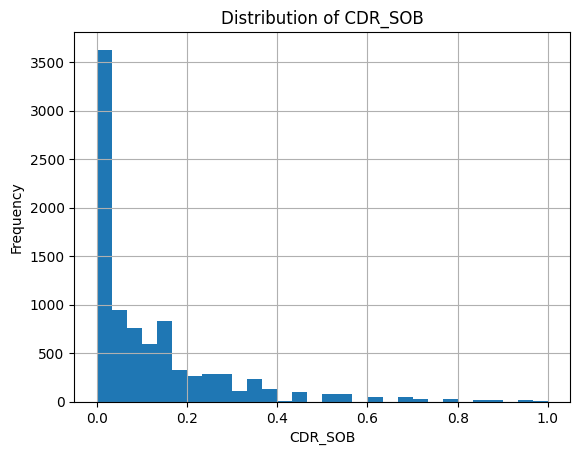

In [ ]:
import matplotlib.pyplot as plt

# Visualize distributions of key cognitive scores
scores = ["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]

for col in scores:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


### Interpretation of Score Distributions

We observe that for all three cognitive scores (MMSE_TOT, ADAS_TOT13, CDR_SOB), the majority of visits are associated with values concentrated in the lower range.

### Identify and Optionally Drop Columns with Too Many Missing Values

Some features, such as MRI volumes, are missing in a large portion of visits (e.g., > 30%).  
We first display these columns, then decide whether to exclude them from modeling.

This helps avoid relying on variables that are rarely available in practice.


In [ ]:
# Step 1: Recompute missing value percentages (just in case)
missing = df.isna().mean().sort_values(ascending=False)

# Step 2: Identify columns with more than 30% missing
high_missing_cols = missing[missing > 0.30].index.tolist()

print("Columns with more than 30% missing values:")
print(high_missing_cols)

# Step 3: Optionally drop them (uncomment if you decide to drop)
df = df.drop(columns=high_missing_cols)



Columns with more than 30% missing values:
['MES_PIB', 'MES_AV45', 'MES_CSF_PTAU_TTAU', 'MES_CSF_TTAU_ABETA42', 'MES_CSF_PTAU', 'MES_CSF_TTAU', 'MES_CSF_ABETA42', 'MES_FDG', 'ECOG_PART_ORGAN', 'ECOG_SELF_ORGAN', 'ECOG_PART_DIVATT', 'MOCA_TOT', 'ECOG_SELF_VISSPAT', 'ECOG_SELF_DIVATT', 'ECOG_PART_VISSPAT', 'ECOG_SELF_PLAN', 'ECOG_SELF_LANG', 'ECOG_SELF_TOTAL', 'ECOG_PART_PLAN', 'ECOG_SELF_MEM', 'ECOG_PART_MEM', 'ECOG_PART_TOTAL', 'ECOG_PART_LANG', 'MES_MRI_ENTORHINAL_ICV', 'MES_MRI_MIDTEMPORAL_ICV', 'MES_MRI_FUSIFORM_ICV', 'MES_MRI_ENTORHINAL_VOL', 'MES_MRI_FUSIFORM_VOL', 'MES_MRI_MIDTEMPORAL_VOL', 'MES_MRI_HIPPOCAMPUS_ICV', 'MES_MRI_HIPPOCAMPUS_VOL']


In [ ]:
df.shape

(9814, 27)

## 4. Summary of Numeric Variables

We compute descriptive statistics for all remaining numeric variables in the dataset.  
This helps us understand typical ranges, detect outliers, and verify the effects of column filtering.

Now that highly incomplete columns have been removed, we can get a clearer picture of the remaining features.


In [ ]:
# Display summary statistics for all remaining numeric features
df.describe()


,EXAMDATE,AGE_vis,SITEID,DX,AGE_bl,YEARS_SINCE_bl,P_YEARS_EDU,P_APOE4,MES_MRI_ICV_VOL,MES_MRI_VENTRICLES_VOL,AVLT_A1t5_SUM_OK,AVLT_A5m1_DELTA_OK,AVLT_A5m7_DELTA_OK,AVLT_A5m7_RATIO_OK,MMSE_TOT,ADAS_TOT11,ADAS_TOT13,CDR_SOB,FAQ_TOT,MES_MRI_VENTRICLES_ICV
count,9814,9814.000000,9814.000000,8847.000000,9814.000000,9814.000000,9814.000000,9813.000000,7.889000e+03,7390.000000,8768.000000,8768.000000,8742.000000,8673.000000,8868.000000,8849.000000,8763.000000,8899.000000,8934.000000,7386.000000
mean,2011-03-03 22:13:02.066435840,75.537160,73.892501,0.926981,73.646332,1.890827,15.991543,0.545908,1.534761e+06,42164.263329,0.540003,0.548512,0.461839,0.638109,0.113490,0.162664,0.205838,0.120647,0.186281,0.484501
min,2005-09-07 00:00:00,55.000000,2.000000,0.000000,55.000000,0.000000,4.000000,0.000000,1.072880e+06,5650.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008-03-06 00:00:00,70.699250,22.000000,0.000000,69.300000,0.383299,14.000000,0.000000,1.417710e+06,25144.750000,0.413333,0.450000,0.400000,0.363636,0.033333,0.076143,0.105882,0.000000,0.000000,0.356913
50%,2011-12-07 00:00:00,75.800000,41.000000,1.000000,73.600000,1.013000,16.000000,0.000000,1.522880e+06,37450.500000,0.560000,0.550000,0.450000,0.659091,0.066667,0.128571,0.176471,0.055556,0.033333,0.482354
75%,2013-05-28 00:00:00,80.799750,116.000000,1.000000,78.600000,2.989730,18.000000,1.000000,1.641190e+06,53436.000000,0.666667,0.650000,0.550000,1.000000,0.166667,0.214286,0.282353,0.166667,0.300000,0.607897
max,2017-05-05 00:00:00,98.602000,941.000000,2.000000,91.400000,10.751500,20.000000,2.000000,2.110290e+06,162729.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,7.397612,108.990220,0.734692,7.029433,2.176533,2.819411,0.658799,1.646757e+05,23284.373954,0.181476,0.140863,0.125437,0.321692,0.131772,0.123475,0.137735,0.156414,0.264233,0.182269


## 5. Build Longitudinal Sequences

To model the progression of Alzheimer's disease, we need to structure the data into sequences.

For each patient:
- We gather a set of past visits (up to a maximum number).
- We then identify future visits at specific time horizons (e.g., 12, 24, 36 months after the last past visit).

We use visit dates to find future visits within a tolerance window (±6 months), and only keep patients with at least one valid future target.

This step produces a list of dictionaries called `patient_splits`.


In [ ]:
def group_visits_by_patient_with_visit_id_and_horizons(
    df,
    id_col="ID",
    date_col="EXAMDATE",
    visit_id_col="VISIT_ID",
    max_visits=5,
    horizons_months=[12, 24, 36],
    target_cols=["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]
):
    df = df.copy()  # Work on a copy of the DataFrame to avoid modifying the original
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")  # Convert date column to datetime
    df = df.dropna(subset=[date_col])  # Drop rows where the date is missing

    grouped = df.groupby(id_col)  # Group data by patient ID
    patient_splits = []  # To store the final list of patient visit splits
    rejected_reasons = []  # To store patients that were rejected and the reason

    for pid, group in grouped:
        group_sorted = group.sort_values(date_col).reset_index()  # Sort visits by date

        if len(group_sorted) < 2:
            # Not enough visits to make a prediction
            rejected_reasons.append((pid, "Too few visits"))
            continue

        # Use up to `max_visits` past visits, exclude the last one which is for future prediction
        nb_past = min(max_visits, len(group_sorted) - 1)
        past_visits = group_sorted.iloc[:nb_past]
        future_visits = group_sorted.iloc[nb_past:]

        if past_visits.empty:
            rejected_reasons.append((pid, "No past visits"))
            continue

        last_past_date = past_visits[date_col].max()  # Date of the most recent past visit

        future_ids_by_horizon = {}
        for h in horizons_months:
            # Define a time window around the expected horizon
            min_date = last_past_date + pd.Timedelta(days=30.44 * (h - 6))
            max_date = last_past_date + pd.Timedelta(days=30.44 * (h + 6))

            # Select future visits within this time window, where at least one target is not missing
            candidates = future_visits[
                (future_visits[date_col] >= min_date) &
                (future_visits[date_col] <= max_date)
            ].dropna(subset=target_cols, how="all")

            if not candidates.empty:
                visit_id = candidates.iloc[0][visit_id_col]
                future_ids_by_horizon[h] = visit_id  # Save the first valid visit for this horizon

        if not future_ids_by_horizon:
            rejected_reasons.append((pid, "No valid future targets"))
            continue

        # Store the valid patient visit split
        patient_splits.append({
            "patient_id": pid,
            "past_visit_ids": past_visits[visit_id_col].tolist(),
            "future_visit_ids_by_horizon": future_ids_by_horizon
        })

    return patient_splits, rejected_reasons


# Apply the function to the full dataset
patient_splits, rejected = group_visits_by_patient_with_visit_id_and_horizons(df)

# Print some basic stats
print(f"Valid patients: {len(patient_splits)}")
print(f"Rejected patients: {len(rejected)}")
print("Example patient split:")
print(patient_splits[0])


Valid patients: 1480
Rejected patients: 199
Example patient split:
{'patient_id': '2334_F_1798', 'past_visit_ids': ['VISIT_09799'], 'future_visit_ids_by_horizon': {24: 'VISIT_09800'}}


## 6. Train / Validation / Test Split

To properly evaluate the model, we divide the patients into three disjoint sets:

- **Train**: used to train the model
- **Validation**: used to tune hyperparameters and apply early stopping
- **Test**: used only for final evaluation, never seen during training

We perform the split at the **patient level**, not at the visit level, to avoid data leakage.


In [ ]:
import random

def split_patient_ids(patient_splits, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Split patient entries into train / val / test lists based on patient_id.
    Output: three lists (train, val, test), each containing patient entries.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    random.seed(seed)
    all_patients = patient_splits.copy()
    random.shuffle(all_patients)

    n = len(all_patients)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_set = all_patients[:n_train]
    val_set = all_patients[n_train:n_train + n_val]
    test_set = all_patients[n_train + n_val:]

    print(f"Train patients: {len(train_set)}")
    print(f"Val patients:   {len(val_set)}")
    print(f"Test patients:  {len(test_set)}")

    return train_set, val_set, test_set

# Apply the split
train_set, val_set, test_set = split_patient_ids(patient_splits)


Train patients: 1036
Val patients:   222
Test patients:  222


## 7. Data Preprocessing: Encoding, Imputation, and Standardization

To prepare the dataset for deep learning, we apply the same preprocessing steps to each split (train, validation, test), but using parameters fitted **only on the training set**.

Steps:
1. Replace `EXAMDATE` with a numerical time value (in months)
2. Remove technical identifiers (`ID`, `VISIT_ID`, `VISCODE`, `EXAMDATE`)
3. Encode categorical features
4. Impute missing values (median)
5. Standardize numerical features

This ensures no information from the validation or test set leaks into training.


In [ ]:
# Extract patient IDs from each split (train, validation, test)
train_ids = set(entry["patient_id"] for entry in train_set)
val_ids = set(entry["patient_id"] for entry in val_set)
test_ids = set(entry["patient_id"] for entry in test_set)

# Filter the original DataFrame to keep only rows for patients in each split
df_train = df[df["ID"].isin(train_ids)].copy()
df_val = df[df["ID"].isin(val_ids)].copy()
df_test = df[df["ID"].isin(test_ids)].copy()

# Print the size of each dataset to check the result
print(f"df_train: {df_train.shape}")
print(f"df_val  : {df_val.shape}")
print(f"df_test : {df_test.shape}")


df_train: (6407, 27)
df_val  : (1404, 27)
df_test : (1340, 27)


In [ ]:
import pandas as pd

def convert_examdate_to_months_since_baseline(df, id_col="ID", date_col="EXAMDATE"):
    df = df.copy()  # Make a copy of the DataFrame to avoid changing the original
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")  # Convert dates to datetime format

    # Find the first (earliest) visit date for each patient (used as baseline)
    baseline_dates = df.groupby(id_col)[date_col].min()

    # Calculate the number of months since the baseline for each visit
    df["MONTHS_SINCE_REF"] = df.apply(
        lambda row: (row[date_col] - baseline_dates.loc[row[id_col]]).days / 30.44
        if pd.notnull(row[date_col]) else None,
        axis=1
    )

    return df.drop(columns=[date_col])  # Drop the original date column

# Apply the transformation to each dataset split
df_train = convert_examdate_to_months_since_baseline(df_train)
df_val = convert_examdate_to_months_since_baseline(df_val)
df_test = convert_examdate_to_months_since_baseline(df_test)

# Check a few results from the training set
df_train[["ID", "MONTHS_SINCE_REF"]].head()


,ID,MONTHS_SINCE_REF
13,3998_F_134,0.000000
14,3998_F_134,5.749014
15,3998_F_134,12.187911
16,3998_F_134,18.134034
17,3998_F_134,36.333771


### Encode Categorical Variables

We apply one-hot encoding to categorical variables using `sklearn.OneHotEncoder`.  
To avoid data leakage, the encoder is fit only on the training set, then applied to validation and test sets.


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Columns used for structure or identification (we don't want to encode them)
structure_cols = ["VISIT_ID", "ID", "VISCODE", "EXAMDATE"]

# Find categorical columns (type "object"), excluding structure columns
categorical_cols = [
    col for col in df_train.select_dtypes(include="object").columns
    if col not in structure_cols
]

print("Categorical columns (to encode):", categorical_cols)

# Initialize one-hot encoder (requires scikit-learn version ≥ 1.2)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Fit the encoder on training data, then apply it to all datasets
encoded_train = encoder.fit_transform(df_train[categorical_cols])
encoded_val = encoder.transform(df_val[categorical_cols])
encoded_test = encoder.transform(df_test[categorical_cols])

# Convert encoded arrays into DataFrames with column names
encoded_train_df = pd.DataFrame(
    encoded_train,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_train.index
)

encoded_val_df = pd.DataFrame(
    encoded_val,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_val.index
)

encoded_test_df = pd.DataFrame(
    encoded_test,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=df_test.index
)

# Drop the original categorical columns, and add the new one-hot encoded columns
df_train = pd.concat([
    df_train.drop(columns=categorical_cols),
    encoded_train_df
], axis=1)

df_val = pd.concat([
    df_val.drop(columns=categorical_cols),
    encoded_val_df
], axis=1)

df_test = pd.concat([
    df_test.drop(columns=categorical_cols),
    encoded_test_df
], axis=1)

# Final check on the shape of the datasets
print(f"Train shape after encoding: {df_train.shape}")
print(f"Val shape after encoding  : {df_val.shape}")
print(f"Test shape after encoding : {df_test.shape}")


Categorical columns (to encode): ['P_GENDER', 'P_RACE', 'P_ETHNICITY', 'P_MARRIED']
Train shape after encoding: (6407, 40)
Val shape after encoding  : (1404, 40)
Test shape after encoding : (1340, 40)


### Impute Missing Values

We fill missing values in numeric columns using the **median** computed from the training set only.  
This strategy is simple, robust to outliers, and helps avoid data leakage between training, validation, and test sets.

We are aware that more advanced imputation methods (e.g., based on domain knowledge, temporal patterns, or multivariate models) could potentially improve performance. However, such methods require expert input and careful design.

Since our current goal is to test a deep learning model quickly and reliably, we adopted this **fast and consistent baseline approach**. It ensures a clean and repeatable preprocessing pipeline, while leaving room for future improvements with the help of medical or domain experts.



In [ ]:
columns_to_exclude = ["VISIT_ID", "ID", "VISCODE", "EXAMDATE"]

# 1. Binary columns: values are only 0.0 or 1.0
binary_cols = [
    col for col in df_train.columns
    if set(df_train[col].dropna().unique()).issubset({0.0, 1.0})
    and col not in columns_to_exclude
]

# 2. Ordinal columns: values are 0.0 / 1.0 / 2.0 (or similar), but not binary
ordinal_cols = [
    col for col in df_train.columns
    if set(df_train[col].dropna().unique()).issubset({0.0, 1.0, 2.0})
    and col not in binary_cols  # make sure it's not already classified as binary
    and col not in columns_to_exclude
]

# 3. Continuous columns: numeric columns that are not binary, not ordinal, and not excluded
continuous_cols = [
    col for col in df_train.select_dtypes(include=["number"]).columns
    if col not in binary_cols + ordinal_cols and col not in columns_to_exclude
]

# Print the result for checking
print("Binary columns   :", binary_cols)
print("Ordinal columns  :", ordinal_cols)
print("Continuous cols  :", continuous_cols)


Binary columns   : ['P_GENDER_Female', 'P_GENDER_Male', 'P_RACE_Am Indian/Alaskan', 'P_RACE_Asian', 'P_RACE_Black', 'P_RACE_Hawaiian/Other PI', 'P_RACE_More than one', 'P_RACE_Unknown', 'P_RACE_White', 'P_ETHNICITY_Hisp/Latino', 'P_ETHNICITY_Not Hisp/Latino', 'P_ETHNICITY_Unknown', 'P_MARRIED_Divorced', 'P_MARRIED_Married', 'P_MARRIED_Never married', 'P_MARRIED_Unknown', 'P_MARRIED_Widowed']
Ordinal columns  : ['DX', 'P_APOE4']
Continuous cols  : ['AGE_vis', 'SITEID', 'AGE_bl', 'YEARS_SINCE_bl', 'P_YEARS_EDU', 'MES_MRI_ICV_VOL', 'MES_MRI_VENTRICLES_VOL', 'AVLT_A1t5_SUM_OK', 'AVLT_A5m1_DELTA_OK', 'AVLT_A5m7_DELTA_OK', 'AVLT_A5m7_RATIO_OK', 'MMSE_TOT', 'ADAS_TOT11', 'ADAS_TOT13', 'CDR_SOB', 'FAQ_TOT', 'MES_MRI_VENTRICLES_ICV', 'MONTHS_SINCE_REF']


In [ ]:
from sklearn.impute import SimpleImputer

# Columns where we want to apply imputation (continuous + ordinal + binary)
cols_to_impute = continuous_cols + ordinal_cols + binary_cols

# Initialize the imputer with the median strategy
imputer = SimpleImputer(strategy="median")

# Create copies of the datasets to avoid modifying the originals
df_train_imputed = df_train.copy()
df_val_imputed = df_val.copy()
df_test_imputed = df_test.copy()

# Fit the imputer on the training set, then apply it to all datasets
df_train_imputed[cols_to_impute] = imputer.fit_transform(df_train[cols_to_impute])
df_val_imputed[cols_to_impute] = imputer.transform(df_val[cols_to_impute])
df_test_imputed[cols_to_impute] = imputer.transform(df_test[cols_to_impute])

# Check if there are any missing values left
print(f"Missing in train after imputation: {df_train_imputed.isna().sum().sum()}")
print(f"Missing in val   after imputation: {df_val_imputed.isna().sum().sum()}")
print(f"Missing in test  after imputation: {df_test_imputed.isna().sum().sum()}")


Missing in train after imputation: 0
Missing in val   after imputation: 0
Missing in test  after imputation: 0


In [ ]:
df_train_imputed.shape

(6407, 40)

### Standardize Continuous Features

Some continuous features have very large value ranges, which can affect model training.  
We manually selected those features and applied standardization (mean = 0, std = 1) using training set statistics.  
This helps the model learn better by keeping feature scales consistent.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Columns we decided to standardize (they have large value ranges)
standardize_cols = [
    'AGE_vis', 'SITEID', 'AGE_bl', 'YEARS_SINCE_bl',
    'P_YEARS_EDU', 'MES_MRI_ICV_VOL', 'MES_MRI_VENTRICLES_VOL', 'MONTHS_SINCE_REF'
]

# Initialize the scaler
scaler = StandardScaler()

# Standardize the selected columns in the training set (fit and transform)
X_train_cont = pd.DataFrame(
    scaler.fit_transform(df_train_imputed[standardize_cols]),
    columns=standardize_cols,
    index=df_train_imputed.index
)

# Apply the same transformation to validation and test sets (transform only)
X_val_cont = pd.DataFrame(
    scaler.transform(df_val_imputed[standardize_cols]),
    columns=standardize_cols,
    index=df_val_imputed.index
)

X_test_cont = pd.DataFrame(
    scaler.transform(df_test_imputed[standardize_cols]),
    columns=standardize_cols,
    index=df_test_imputed.index
)




### Recombine All Features

We now combine:
- Standardized continuous variables
- Unscaled ordinal and binary variables
to form the final training, validation, and test feature sets.


In [ ]:
# Reconstruct the final matrices by combining all relevant columns

X_train = pd.concat([
    X_train_cont,  # standardized continuous features
    df_train_imputed[ordinal_cols + binary_cols + ["DX", "MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]],  # other useful features
    df_train[["ID", "VISCODE", "VISIT_ID"]]  # structural columns (patient and visit info)
], axis=1)

X_val = pd.concat([
    X_val_cont,
    df_val_imputed[ordinal_cols + binary_cols + ["DX", "MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]],
    df_val[["ID", "VISCODE", "VISIT_ID"]]
], axis=1)

X_test = pd.concat([
    X_test_cont,
    df_test_imputed[ordinal_cols + binary_cols + ["DX", "MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]],
    df_test[["ID", "VISCODE", "VISIT_ID"]]
], axis=1)

# Final check on the shapes of the datasets
print("Final shapes:")
print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)


Final shapes:
X_train: (6407, 34)
X_val  : (1404, 34)
X_test : (1340, 34)


## Feature Correlation with Cognitive Scores

We analyze how each preprocessed feature correlates with the three cognitive target scores:

- MMSE_TOT
- ADAS_TOT13
- CDR_SOB

We display only the top 10 most correlated features for each score.


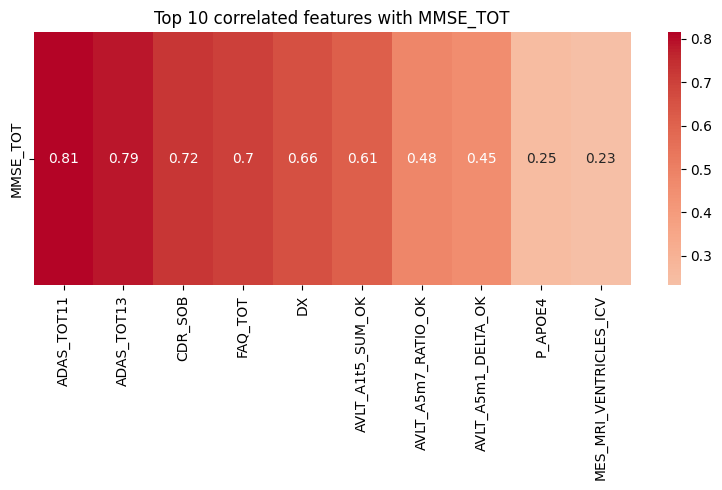

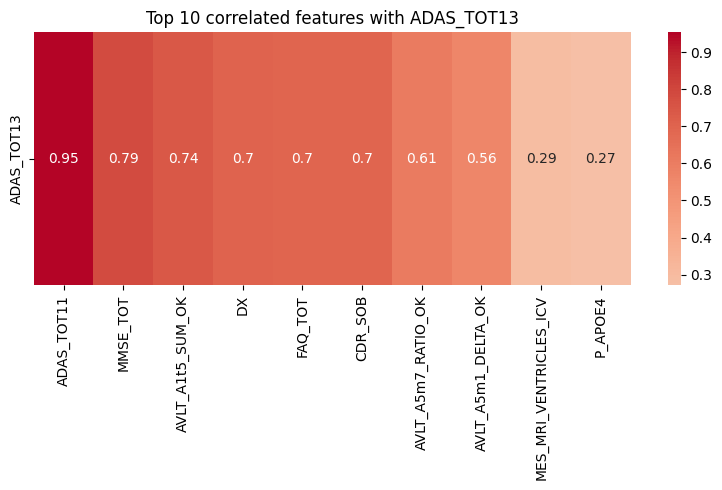

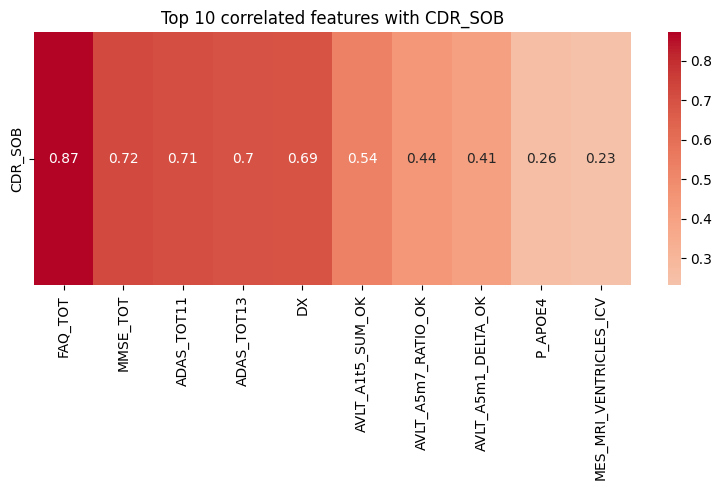

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Colonnes à exclure
excluded_columns = ["ID", "VISIT_ID", "VISCODE"]

# Créer une copie sans les colonnes exclues
df_corr = df_train_imputed.drop(columns=[col for col in excluded_columns if col in df_train_imputed.columns])

# Matrice de corrélation
corr_matrix = df_corr.corr()

# Affichage des top 10 features corrélées par score cible
for score in ["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]:
    if score not in corr_matrix.columns:
        continue  # sécurité si le score n'est pas présent

    plt.figure(figsize=(8, 5))

    # Corrélations absolues triées (hors la cible elle-même)
    sorted_corr = corr_matrix[score].drop(labels=[score], errors="ignore").abs().sort_values(ascending=False).head(10)

    # Extraire les vraies valeurs (signées)
    top_corr = corr_matrix.loc[sorted_corr.index, score]

    sns.heatmap(top_corr.to_frame().T, annot=True, cmap="coolwarm", center=0)
    plt.title(f"Top 10 correlated features with {score}")
    plt.tight_layout()
    plt.show()


## Building Longitudinal Sequences for Modeling

We now use the structured information (train/val/test patient splits) to construct input sequences (`X`) and target vectors (`y`) for modeling.

Each patient's sequence contains all their past visits (as features), and the targets are their cognitive scores at different future time horizons (12, 24, 36 months).

At this stage, we do **not apply padding**. Only valid sequences are returned.


In [ ]:
def build_X_y_sequences_from_visit_ids(
    df,
    patient_split,
    target_cols=["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"],
    id_col="VISIT_ID"
):
    """
    Build X (sequences of past visits) and y (future target values at different horizons)
    using the patient_split structure, which contains ordered visit_ids and future targets.
    """
    X, y, patient_ids = [], [], []

    for entry in patient_split:
        pid = entry["patient_id"]
        past_ids = entry["past_visit_ids"]
        future_ids_by_horizon = entry.get("future_visit_ids_by_horizon", {})

        # Filter the DataFrame for past visits
        df_past = df[df[id_col].isin(past_ids)]
        if df_past.empty or df_past.shape[0] < 1:
            continue  # skip if no valid past visits

        # Reorder the past visits exactly as in past_ids
        df_past = pd.concat(
            [df[df[id_col] == vid] for vid in past_ids if vid in df[id_col].values],
            ignore_index=True
        )

        # Drop non-feature columns (structural columns)
        drop_cols = ['VISIT_ID', 'ID', 'VISCODE', 'EXAMDATE']
        drop_cols = [col for col in drop_cols if col in df_past.columns]
        X_values = df_past.drop(columns=drop_cols).values  # input sequence for this patient

        # Build target values at 12, 24, and 36 months
        y_patient = []
        for h in [12, 24, 36]:
            future_id = future_ids_by_horizon.get(h, None)
            if future_id:
                df_future = df[df[id_col] == future_id]
                if not df_future.empty:
                    y_values = df_future[target_cols].iloc[0].values
                else:
                    y_values = [np.nan] * len(target_cols)  # missing values
            else:
                y_values = [np.nan] * len(target_cols)  # no visit found for this horizon
            y_patient.append(y_values)

        # Skip if all targets are missing
        if np.all(np.isnan(y_patient)):
            continue

        # Store the sequence, target, and patient ID
        X.append(X_values)
        y.append(np.array(y_patient))
        patient_ids.append(pid)

    return X, y, patient_ids


In [ ]:
import numpy as np

# Build sequences of past visits (X) and future targets (y) for each dataset split
X_seq_train, y_seq_train, ids_train = build_X_y_sequences_from_visit_ids(X_train, train_set)
X_seq_val, y_seq_val, ids_val = build_X_y_sequences_from_visit_ids(X_val, val_set)
X_seq_test, y_seq_test, ids_test = build_X_y_sequences_from_visit_ids(X_test, test_set)

# Check how many sequences were created for each split
print(" Sequences built:")
print("X_seq_train:", len(X_seq_train), "y_seq_train:", len(y_seq_train))
print("X_seq_val  :", len(X_seq_val), "y_seq_val  :", len(y_seq_val))
print("X_seq_test :", len(X_seq_test), "y_seq_test :", len(y_seq_test))

# Show one example sequence from the training set
print("\n Example sequence shape (train):", X_seq_train[0].shape)
print("y_seq_train[0] =", y_seq_train[0])



 Sequences built:
X_seq_train: 1036 y_seq_train: 1036
X_seq_val  : 222 y_seq_val  : 222
X_seq_test : 222 y_seq_test : 222

 Example sequence shape (train): (5, 31)
y_seq_train[0] = [[0.33333333 0.44317647 0.33333333]
 [       nan        nan        nan]
 [       nan        nan        nan]]


## 6. Padding Longitudinal Sequences

Each patient has a variable number of past visits, which makes the sequences irregular in length.  
In order to train deep learning models such as RNNs or LSTMs, we need to transform them into tensors of equal shape.

To do this, we apply **pre-padding** to all sequences. This means that zeros are added at the beginning of the sequence, preserving the temporal order (recent visits remain at the end).

We use the maximum sequence length observed in the training set to determine the padding size.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find the maximum sequence length from the training set
max_seq_len = max(len(seq) for seq in X_seq_train)
print(f" Max sequence length (train set): {max_seq_len}")

# Apply padding to all sequences so they have the same length
# Padding is added at the beginning ('pre') to keep the most recent visits at the end
X_seq_train_padded = pad_sequences(X_seq_train, maxlen=max_seq_len, padding='pre', dtype='float32')
X_seq_val_padded   = pad_sequences(X_seq_val,   maxlen=max_seq_len, padding='pre', dtype='float32')
X_seq_test_padded  = pad_sequences(X_seq_test,  maxlen=max_seq_len, padding='pre', dtype='float32')

# Convert the target lists into NumPy arrays
y_seq_train = np.array(y_seq_train, dtype='float32')
y_seq_val   = np.array(y_seq_val, dtype='float32')
y_seq_test  = np.array(y_seq_test, dtype='float32')

# Check the final shapes of input and target arrays
print(" Final shapes:")
print("X_seq_train_padded:", X_seq_train_padded.shape)
print("y_seq_train        :", y_seq_train.shape)


 Max sequence length (train set): 5
 Final shapes:
X_seq_train_padded: (1036, 5, 31)
y_seq_train        : (1036, 3, 3)


In [ ]:
#Example of a sequence
X_seq_train_padded[0]

array([[ 0.31569663, -0.5404594 ,  0.6088508 , -0.90463346, -1.7242228 ,
        -0.4406529 ,  1.5620166 , -0.90463346,  1.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.03333334,  0.32152942,
         0.1388889 ],
       [ 0.37536463, -0.5404594 ,  0.6088508 , -0.70059544, -1.7242228 ,
        -0.53093183,  1.6971916 , -0.7005955 ,  1.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.06666667,  0.22741176,
         0.05555556],
       [ 0.44336468, -0.5404594 ,  0.6088508 , -0.46758923, -1.7242228 ,
       

## 7. Modeling Cognitive Score Trajectories with BiLSTM

To predict the future cognitive state of each patient at 12, 24, and 36 months, we use a deep learning model based on bidirectional LSTM (BiLSTM) layers. This architecture is well suited for handling sequential data, as it captures both past and future dependencies in the time series.

Each input sequence corresponds to a patient's visits over time (padded to a uniform length), and each output is a vector of predicted cognitive scores at multiple future time horizons.

We define the model with the following characteristics:
- Input shape: `(sequence_length, n_features)`
- Output shape: `(n_horizons, n_targets)` where:
  - `n_horizons = 3` (for 12, 24, and 36 months)
  - `n_targets = 3` (MMSE_TOT, ADAS_TOT13, and CDR_SOB)

We use a custom masked loss and metric to handle missing labels.

### 7.1 Custom Loss and Metrics for Missing Labels

Some target values may be missing (NaN) for certain patients and time horizons. To train the model correctly, we define masked versions of MSE (loss) and MAE (metric), which ignore missing values during training and evaluation.


In [ ]:
# TensorFlow Keras layers and models
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [ ]:
def masked_mse_loss(y_true, y_pred):
    """
    Mean Squared Error (MSE) that ignores missing values (NaNs) in the targets.

    Args:
        y_true: tensor of shape (batch_size, n_horizons, n_targets)
        y_pred: model predictions, same shape

    Returns:
        Normalized MSE computed only on valid (non-NaN) targets.
    """
    # Create a boolean mask: True where y_true is not NaN
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    mask = tf.cast(mask, tf.float32)  # convert mask to float for multiplication

    # Replace NaNs in y_true with zeros (they won't affect the loss due to the mask)
    y_true_clean = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)

    # Compute squared error and apply the mask
    squared_error = tf.square(y_pred - y_true_clean) * mask

    # Return the mean squared error over valid values only
    return tf.reduce_sum(squared_error) / tf.reduce_sum(mask)


def masked_mae(y_true, y_pred):
    """
    Mean Absolute Error (MAE) that ignores missing values (NaNs) in the targets.
    """
    # Create a mask for non-NaN values
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    mask = tf.cast(mask, tf.float32)

    # Replace NaNs with zeros
    y_true_clean = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)

    # Compute absolute error and apply the mask
    abs_error = tf.abs(y_pred - y_true_clean) * mask

    # Return the mean absolute error over valid values only
    return tf.reduce_sum(abs_error) / tf.reduce_sum(mask)


### 7.2 Model Architecture – Stacked BiLSTM

We build a model with two stacked Bidirectional LSTM layers. The final output is reshaped into three predicted cognitive scores at three time horizons.


In [ ]:
def build_bilstm_stack_model(seq_len, n_features, n_horizons, n_targets,
                             lstm_units=16, dropout_rate=0.0):
    """
    Builds a BiLSTM-based model for multi-horizon prediction.

    Args:
        seq_len: Number of time steps in the input sequence
        n_features: Number of input features per time step
        n_horizons: Number of time horizons to predict (e.g. [12, 24, 36])
        n_targets: Number of target variables at each horizon
        lstm_units: Number of units in each LSTM direction
        dropout_rate: Dropout rate (0.0 means no dropout)

    Returns:
        A compiled tf.keras.Model
    """

    # Input shape: (batch_size, seq_len, n_features)
    inputs = layers.Input(shape=(seq_len, n_features))

    # Ignore time steps that are padded with zeros
    x = layers.Masking(mask_value=0.0)(inputs)

    # First BiLSTM layer (returns sequences to stack another LSTM)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    # Second BiLSTM layer (returns the final output only)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    # Final dense layer to predict all targets at all horizons
    x = layers.Dense(n_horizons * n_targets, activation="sigmoid")(x)

    # Reshape output to (n_horizons, n_targets)
    outputs = layers.Reshape((n_horizons, n_targets))(x)

    # Build the model
    model = models.Model(inputs, outputs)
    return model


### 7.3 Model Compilation and Training

We compile the model using the Adam optimizer and our custom masked loss/metric functions. We apply early stopping and save the best model using validation loss.


In [ ]:
# Model parameters
seq_len = X_seq_train_padded.shape[1]        # maximum sequence length after padding
n_features = X_seq_train_padded.shape[2]     # number of features per visit
n_horizons = y_seq_train.shape[1]            # e.g., 3 horizons (12, 24, 36 months)
n_targets = y_seq_train.shape[2]             # e.g., 3 targets: MMSE, ADAS, CDR

# Build the BiLSTM model
model = build_bilstm_stack_model(
    seq_len=seq_len,
    n_features=n_features,
    n_horizons=n_horizons,
    n_targets=n_targets,
    lstm_units=32,        # number of LSTM units per direction
    dropout_rate=0.2      # dropout between layers to prevent overfitting
)

# Compile the model with masked MSE loss and masked MAE as metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=masked_mse_loss,       # ignores missing targets (NaNs)
    metrics=[masked_mae]        # custom MAE that also ignores NaNs
)

# Show model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 31)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 5, 31)     │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 5, 31)     │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 5)         │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 5, 64)     │     16,384 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 64)     │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     24,832 │ dropout_2[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │        585 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 3)      │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,801 (163.29 KB)

 Trainable params: 41,801 (163.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model (based on lowest validation loss)
checkpoint_cb = ModelCheckpoint(
    "best_model.keras",       # file to save the best model
    monitor="val_masked_mae",       # monitor validation loss
    save_best_only=True,      # only save the model when val_loss improves
    save_weights_only=False,  # save the entire model (not just weights)
    verbose=1                 # print a message when a new best model is saved
)


In [ ]:
# Training
history = model.fit(
    X_seq_train_padded, y_seq_train,
    validation_data=(X_seq_val_padded, y_seq_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint_cb],
    verbose=1
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1026 - masked_mae: 0.2865
Epoch 1: val_masked_mae improved from inf to 0.15097, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - loss: 0.1019 - masked_mae: 0.2851 - val_loss: 0.0404 - val_masked_mae: 0.1510
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0321 - masked_mae: 0.1332
Epoch 2: val_masked_mae improved from 0.15097 to 0.13210, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0321 - masked_mae: 0.1331 - val_loss: 0.0336 - val_masked_mae: 0.1321
Epoch 3/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0282 - masked_mae: 0.1246
Epoch 3: val_masked_mae improved from 0.13210 to 0.11902, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0282 - masked_mae: 0.1246 - val_loss: 0.0280 - val_masked_mae: 0.1190
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224 - masked_mae: 0.1097
Epoch 4: val_masked_m

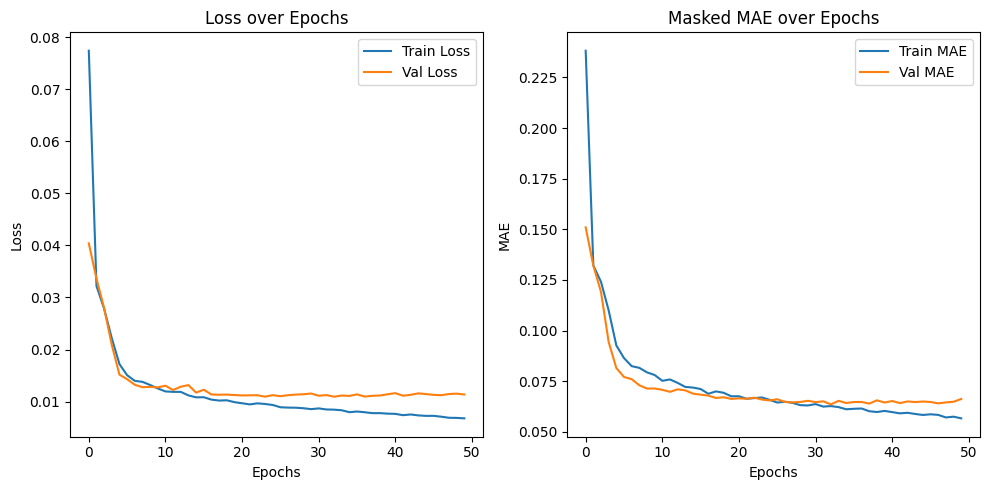

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(10, 5))  # create a wide figure for side-by-side plots

    # Plot the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the masked MAE curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['masked_mae'], label='Train MAE')
    if 'val_masked_mae' in history.history:
        plt.plot(history.history['val_masked_mae'], label='Val MAE')
    plt.title('Masked MAE over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_history(history)


### 7.4 Model Evaluation

We evaluate the best saved model on the test set using our custom masked loss and metric functions.  
This ensures that missing targets (NaNs) do not affect the results.

In [ ]:
from tensorflow.keras.models import load_model


## Load the best model
best_model = load_model("best_model.keras", custom_objects={
    "masked_mse_loss": masked_mse_loss,
    "masked_mae": masked_mae
})

In [ ]:
# Evaluate the best saved model on the test set
test_loss, test_mae = best_model.evaluate(X_seq_test_padded, y_seq_test, verbose=1)

# Print the results
print(f"Test loss (masked MSE): {test_loss:.4f}")
print(f"Test MAE (masked):      {test_mae:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - masked_mae: 0.0583
Test loss (masked MSE): 0.0070
Test MAE (masked):      0.0567


The model was evaluated using masked loss functions.

- **Masked Mean Squared Error (MSE)**: `0.0070`
- **Masked Mean Absolute Error (MAE)**: `0.0567`

Since the target scores were standardized (mean = 0, standard deviation = 1), this result means that the model's predictions have an average error of about **5.7% of one standard deviation** across all targets and time horizons.



To better understand the model’s output, we select one patient from the test set and display the predicted vs. true cognitive scores.

The model predicts three scores (`MMSE_TOT`, `ADAS_TOT13`, and `CDR_SOB`) at three future time points: 12, 24, and 36 months.

This example helps us qualitatively evaluate the model’s behavior and how well it anticipates patient progression.


In [ ]:
import numpy as np

# Choose a sample from the test set (example at index 22)
idx = 22

# Input: sequence of past visits (add batch dimension)
x_sample = X_seq_test_padded[idx:idx+1]  # shape: (1, seq_len, n_features)
y_true = y_seq_test[idx]                 # shape: (n_horizons, n_targets)

# Predict future scores using the trained model
y_pred = best_model.predict(x_sample)[0]  # remove batch dimension → shape: (n_horizons, n_targets)

# Define time horizons and target score names
horizons = [12, 24, 36]
target_cols = ["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]

# Print predicted vs true values for each horizon and each target
for i, h in enumerate(horizons):
    print(f"Horizon {h} months:")
    for j, target in enumerate(target_cols):
        val_pred = y_pred[i][j]
        val_true = y_true[i][j]
        if np.isnan(val_true):
            print(f"  - {target}: prediction = {val_pred:.4f} | true = NaN (missing)")
        else:
            print(f"  - {target}: prediction = {val_pred:.4f} | true = {val_true:.4f}")
    print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Horizon 12 months:
  - MMSE_TOT: prediction = 0.0452 | true = 0.2000
  - ADAS_TOT13: prediction = 0.1509 | true = 0.1647
  - CDR_SOB: prediction = 0.0507 | true = 0.0556
------------------------------
Horizon 24 months:
  - MMSE_TOT: prediction = 0.0536 | true = 0.1667
  - ADAS_TOT13: prediction = 0.1535 | true = 0.2118
  - CDR_SOB: prediction = 0.0569 | true = 0.0278
------------------------------
Horizon 36 months:
  - MMSE_TOT: prediction = 0.0629 | true = 0.0667
  - ADAS_TOT13: prediction = 0.1678 | true = 0.1726
  - CDR_SOB: prediction = 0.0629 | true = 0.0000
------------------------------


### 7.7 Error Distribution per Target Variable

To better understand how the model performs on each cognitive score, we compute the **absolute error** (MAE) between the true and predicted values on the test set.

We only include non-missing targets, and we visualize the results using a boxplot for each target variable (`MMSE_TOT`, `ADAS_TOT13`, and `CDR_SOB`).

This helps identify which score is more difficult to predict and whether the model is consistently accurate across all targets.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


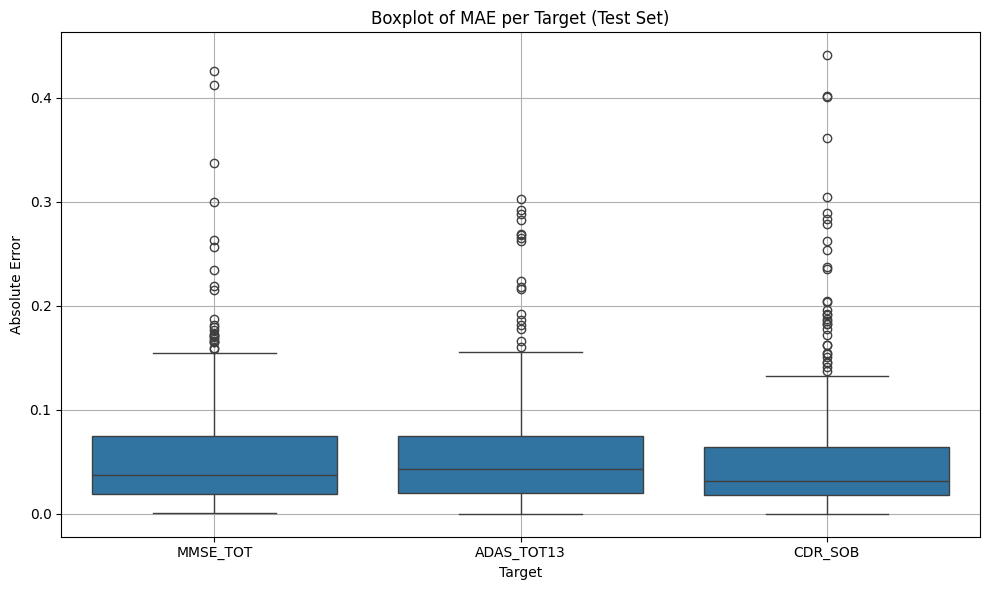

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get predictions from the best model
y_pred = best_model.predict(X_seq_test_padded)

# Convert true and predicted targets to NumPy arrays
y_true_np = np.array(y_seq_test)
y_pred_np = np.array(y_pred)

# Compute absolute error (MAE) for each prediction
# Shape: (n_samples, n_horizons, n_targets)
mae_matrix = np.abs(y_true_np - y_pred_np)

# Target names (adjust if needed)
target_names = ["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]
n_horizons = y_true_np.shape[1]
n_targets = y_true_np.shape[2]

# Collect valid (non-NaN) errors in a list for plotting
data = []

for i in range(len(X_seq_test_padded)):        # for each test sample
    for h in range(n_horizons):                # for each horizon (e.g., 12, 24, 36 months)
        for t in range(n_targets):             # for each target variable
            true_val = y_true_np[i, h, t]
            pred_val = y_pred_np[i, h, t]
            if not np.isnan(true_val):         # only include valid values
                data.append({
                    "Target": target_names[t],
                    "Horizon (months)": [12, 24, 36][h],
                    "Absolute Error": abs(true_val - pred_val)
                })

# Convert to DataFrame for visualization
df_errors = pd.DataFrame(data)

# Boxplot of absolute error per target
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_errors, x="Target", y="Absolute Error")
plt.title("Boxplot of MAE per Target (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()




The boxplot above shows the distribution of absolute errors (MAE) for each predicted cognitive score on the test set.

- The median error is low and similar across all three targets: `MMSE_TOT`, `ADAS_TOT13`, and `CDR_SOB`.
- Most prediction errors fall below 0.1 (in normalized units), indicating consistent and reliable performance.
- A few outliers exist with higher errors, but they remain relatively rare.
- Overall, the model performs equally well across the three cognitive targets, with stable error distributions.


(2, 57)

### 8. Prediction for the Clinician's Patient

We used the two visits provided by the clinician to predict the patient's cognitive status in 12, 24, and 36 months.

The prediction was made using our trained model based on historical data from many Alzheimer's patients.

This gives an estimate of how the patient's condition may change over time and can help support clinical decisions.


### 8.1 Preparing the Clinician's Patient for Prediction

We preprocess the new patient's data (`clinician_patient.csv`) using the **same pipeline** as during training:

- Convert visit dates to months since baseline
- Drop high-missing columns
- Encode categorical variables with the trained encoder
- Impute missing values with the trained imputer
- Standardize selected continuous features
- Reconstruct the final input matrix with all required variables
- **Apply padding** so that the input sequence matches the expected shape used during training (`seq_len`)

At the end, the patient's data is converted into a padded input array (`X_new_padded`) that can be used directly for prediction with the BiLSTM model.


In [ ]:
# === 1. Load the new patient file ===
df_new = pd.read_csv("clinician_patient.csv")
df_new.shape

# Convert exam dates to "months since baseline"
df_new = convert_examdate_to_months_since_baseline(df_new)

# === 3. Drop columns with too many missing values (same as in training) ===
df_new = df_new.drop(columns=high_missing_cols, errors="ignore")  # comes from training preprocessing

# === 4. Encode categorical variables using the trained encoder ===
df_new_encoded = df_new.copy()
df_new_encoded = pd.concat([
    df_new_encoded.drop(columns=categorical_cols, errors="ignore"),
    pd.DataFrame(
        encoder.transform(df_new[categorical_cols]),  # use the same encoder as in training
        columns=encoder.get_feature_names_out(categorical_cols),
        index=df_new.index
    )
], axis=1)

# === 5. Impute missing values using the trained imputer ===
df_new_imputed = df_new_encoded.copy()
df_new_imputed[cols_to_impute] = imputer.transform(df_new_encoded[cols_to_impute])

# === 6. Standardize selected continuous features using the trained scaler ===
X_new_cont = pd.DataFrame(
    scaler.transform(df_new_imputed[standardize_cols]),
    columns=standardize_cols,
    index=df_new.index
)

# === 7. Rebuild the final input matrix with all required columns ===
X_new_final = pd.concat([
    X_new_cont,
    df_new_imputed[ordinal_cols + binary_cols + ["DX", "MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]],
    df_new[["ID", "VISCODE"]]  # keep identifiers
], axis=1)

# === 8. Convert to numpy array for model input ===
X_new_array = X_new_final.drop(columns=["ID", "VISCODE"]).to_numpy()


print("Shape of X_new_array:", X_new_array.shape)


Shape of X_new_array: (2, 31)


In [ ]:
import numpy as np

def pad_patient_sequence(X_new_array, max_visits, n_features, pad_value=0.0):
    """
    Applique un padding à gauche sur un tableau de forme (T, n_features) pour qu'il devienne (max_visits, n_features)

    Args:
        X_new_array: array de forme (T, n_features)
        max_visits: nombre de visites max (doit venir de l'entraînement)
        n_features: nombre de features par visite
        pad_value: valeur utilisée pour le padding (par défaut 0.0)

    Returns:
        X_padded: array de forme (1, max_visits, n_features) prêt à être donné au modèle
    """
    T = X_new_array.shape[0]

    if T > max_visits:
        X_new_array = X_new_array[-max_visits:]  # On garde les dernières visites

    X_padded = np.full((max_visits, n_features), pad_value, dtype=np.float32)
    X_padded[-T:] = X_new_array  # Padding à gauche

    return X_padded[np.newaxis, ...]  # (1, max_visits, n_features)


In [ ]:
# Suppose que X_new_array est de taille (3, 31)
max_visits = X_seq_test_padded.shape[1]       # Par exemple, 5
n_features = X_seq_test_padded.shape[2]       # Par exemple, 31

X_new_padded = pad_patient_sequence(X_new_array, max_visits, n_features)
print("New patient ready for prediction.")
print("Shape padded:", X_new_padded.shape)

New patient ready for prediction.
Shape padded: (1, 5, 31)


### 8.2 Visualizing Predicted Trajectories for the Clinician's Patient

We now visualize the predicted evolution of the clinician’s patient for each cognitive score.

- We use the patient's two past visits (`MMSE_TOT`, `ADAS_TOT13`, and `CDR_SOB`) along with the visit dates.
- We predict future values at 12, 24, and 36 months using our trained model.
- For each target, we plot both the known past values and the predicted future values over time.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


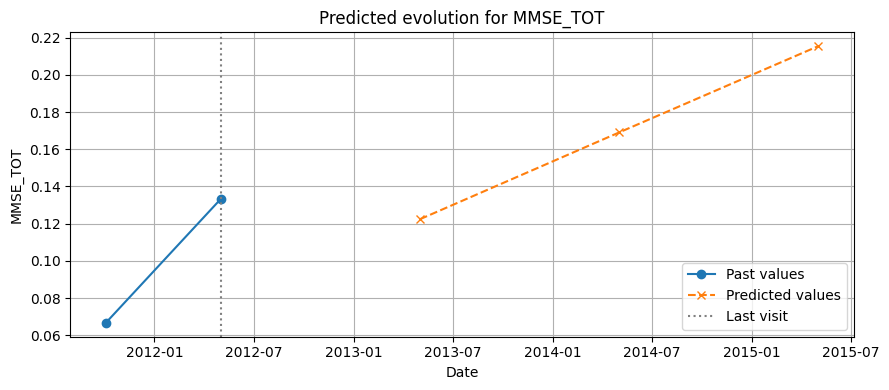

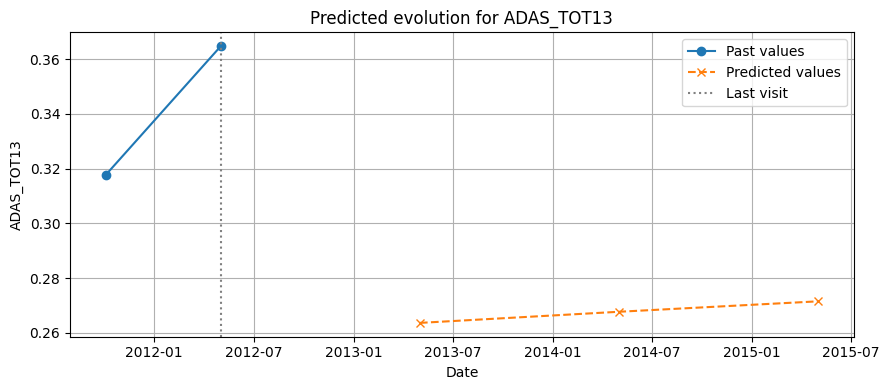

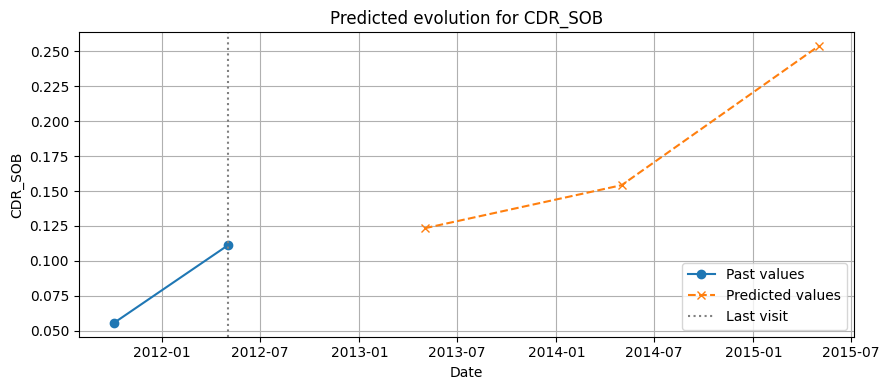

In [ ]:
# Assumptions:
# - df_new contains the patient's past visits with columns: EXAMDATE, MMSE_TOT, ADAS_TOT13, CDR_SOB
# - X_new_padded is ready and passed into the model
# - best_model is loaded
# - Targets are in the following order:
target_cols = ["MMSE_TOT", "ADAS_TOT13", "CDR_SOB"]
horizons = [12, 24, 36]

# 1. Get the dates of the past visits
dates_past = pd.to_datetime(df_new["EXAMDATE"].values[:X_new_padded.shape[1]])

# 2. Get the past target values (e.g. MMSE, ADAS, CDR)
past_targets = {col: df_new[col].values[:X_new_padded.shape[1]] for col in target_cols}

# 3. Predict future target values for the new patient
y_pred = best_model.predict(X_new_padded)[0]  # shape: (3 time points, 3 targets)

# 4. Create future dates based on the last known visit
last_date = dates_past[-1]
future_dates = [last_date + pd.DateOffset(months=h) for h in horizons]

# 5. Plot past and predicted future values for each target
for i, target in enumerate(target_cols):
    plt.figure(figsize=(9, 4))

    # Plot past values
    plt.plot(dates_past, past_targets[target], marker='o', label='Past values')

    # Plot future predictions
    plt.plot(future_dates, y_pred[:, i], marker='x', linestyle='--', label='Predicted values')

    # Mark the last known visit
    plt.axvline(last_date, color='gray', linestyle=':', label='Last visit')

    plt.title(f"Predicted evolution for {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


We used our trained BiLSTM model to forecast the patient’s cognitive scores — **MMSE_TOT**, **ADAS_TOT13**, and **CDR_SOB** — over the next 12, 24, and 36 months.

- The model was provided with two past visits from the clinician.
- These visits were processed using the same pipeline as in training:
  - Categorical encoding
  - Missing value imputation
  - Feature standardization
  - Sequence padding

The resulting input was passed into the model to generate predictions at future time horizons.

### Model Reliability

- On the held-out test set, the model achieved a **masked MAE of ~0.0567**, meaning an average absolute error of about **5.7% on normalized scores**.
- Since the new patient was preprocessed consistently and meets similar input conditions, the model's forecast can be considered **technically reliable**.

>  **Note**: This interpretation is purely technical from a machine learning perspective and does not constitute any clinical advice or diagnosis.


## Model Limitations

In [ ]:
## Calcule the Global missing target values in training set

# y_seq_train has shape (n_samples, n_horizons, n_targets)
total_values = np.prod(y_seq_train.shape)
missing_values = np.isnan(y_seq_train).sum()
missing_percentage = 100 * missing_values / total_values

print(f" Global missing target values: {missing_percentage:.2f}%")


 Global missing target values: 48.33%


### Model Limitations

Despite encouraging results, our model has several limitations from a machine learning perspective:

- **Limited training data**: The number of available patients with longitudinal follow-up is limited, which may reduce generalization capabilities.
- **High percentage of missing target values**: Many future visits lack one or more cognitive scores, reducing supervision during training.
  - For example, **48.33% of all target values (MMSE_TOT, ADAS_TOT13, CDR_SOB across 12/24/36 months)** are missing in the training data.
- **Irregular visit patterns**: Although we predict fixed horizons (12/24/36 months), real-world visit dates are often irregular.
- **No domain-driven feature selection**: Features were selected automatically, without expert validation on clinical relevance.
- **No multimodal inputs**: Our model only uses tabular numeric features; it does not integrate MRI, PET scans, or clinical notes, which could boost accuracy.

